In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset
*   Number of train samples: 7613
*   Number of test samples: 3263

The task is binary class classificatoin, and our goal is to train a model that can read the tweets and distinguish real disasters from false.

# EDA
*   The labels are fairly balanced.
*   Most of the tweets are between 20 to 30 words.
*   There are stopwords in our samples, and the most common ones are: the, a, to ...etc.
*   There are punctuation, emoji and URLs in our samples.

# Preprocessing
1.   I removed URLS, stopwords and puncuation from our samples.
2.   I left emojis because they might be meaningful in certain ways.
3.   I used GloVe 6B-50d for encoding our text data. 

# Model structure
I trained three models for comparison:
1. SimpleRNN
2. LSTM
3. GRU

Each model has similiar structure: embedding layer, RNN layer and finally dense layer for classification.


# Results
LSTM and GRU had similar performance, and they outperformed the SimpleRNN model.
Our models learned sufficiently after the first few epochs but encountered overfitting issues as the training continued. For the detailed informatoin, please check the graph below.

# Discussions
1. We can possibly avoid or alleviate the overfitting issues by adding more layers and parameters into the models.
2. We can possibly avoid or alleviate the overfitting issues by adding dropouts, batch normalization or regulation layers.
3. Pre-trained models specifically trained for medical images should have much beter results than the naive model in this notebook. Unfortunately, under the
scope of this project, I did not investigate those possibilities.



In [2]:
import numpy as np
import pandas as pd

import os
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import re
import string
import nltk
from nltk.corpus import stopwords

# Model artchitecture
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,LSTM,GRU,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Training
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/tweeter_disaster'

os.listdir(working_dir)

['data', 'checkpoint', 'dev.ipynb']

In [4]:
# Loading data

train = working_dir + '/data/train.csv'
test = working_dir + '/data/test.csv'

train = pd.read_csv(train)
test = pd.read_csv(test)

print(train.shape)
print(test.shape)

train.columns

(7613, 5)
(3263, 4)


Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

# EDA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'counts')

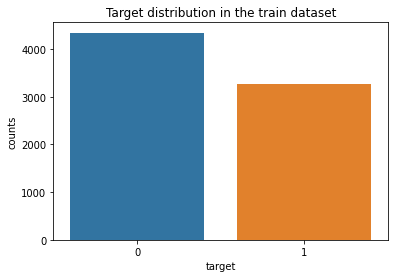

In [5]:
# Show class distribution 
data = train['target'].value_counts()
sns.barplot(data.index, data)
plt.title('Target distribution in the train dataset')
plt.xlabel('target')
plt.ylabel('counts')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# samples')

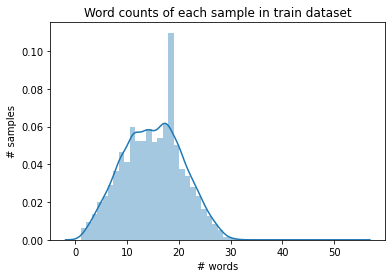

In [6]:
# Word count
word_counts = train['text'].apply(lambda x: len(x.split(' ')))
sns.distplot(word_counts)

plt.title('Word counts of each sample in train dataset')
plt.xlabel('# words')
plt.ylabel('# samples')

Number of words in all text in train dataset:  113654


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '# words')

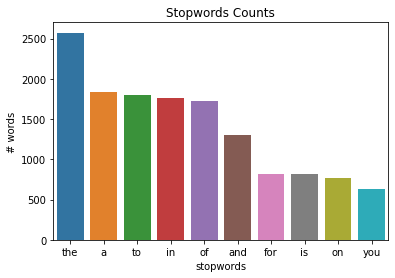

In [7]:
# Generate a giant list for all words in train dataset
ls_text = train['text'].apply(lambda x: x.split(' '))

concat_text = list()
for i in range(len(ls_text)):
  concat_text += ls_text[i]

print('Number of words in all text in train dataset: ', len(concat_text))

# Stopwords 
try: 
  stop_words = stopwords.words('english')
except:
  nltk.download('stopwords')
  stop_words = stopwords.words('english')

# filter stopwords from the Counter(concat_text)
word_counts = Counter({k:v for k,v in Counter(concat_text).items() if k in stop_words}).most_common(10)
ls_stpwords = [k for (k,v) in word_counts]
ls_counts = [v for (k,v) in word_counts]

sns.barplot(ls_stpwords, ls_counts)
plt.title('Stopwords Counts')
plt.xlabel("stopwords")
plt.ylabel('# words')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '# appearance')

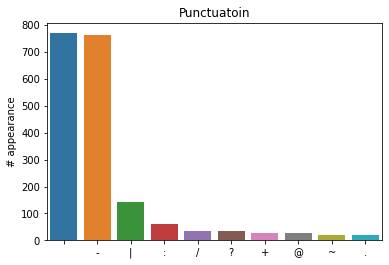

In [8]:
# Punctuation
word_counts = Counter({k:v for k,v in Counter(concat_text).items() if k in string.punctuation}).most_common(10)
ls_stpwords = [k for (k,v) in word_counts]
ls_counts = [v for (k,v) in word_counts]

sns.barplot(ls_stpwords, ls_counts)
plt.title('Punctuatoin')
plt.ylabel('# appearance')

# Preprocessing


1.   Remove URLs
2.   Remove stopwords
3.   Remove punctuation



In [9]:
def process_text(text):
  # remove URLS
  text = re.sub(r'https?:\/\/\S+', '', text)

  # remove stopwords and punctuation
  text = text.split(' ')
  text = [word for word in text if word not in stop_words and word not in string.punctuation]
  return text


In [10]:
train['text'] = train['text'].apply(lambda x: process_text(x))
test['text'] = test['text'].apply(lambda x: process_text(x))

# Encoding


In [11]:
# Loading word embeddings of GloVe
embeddings_index = {}
glove_path = working_dir + '/data/glove.6B.50d.txt'
with open(glove_path, 'r', encoding='utf8') as f:
  for eid,line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('# words in the embedding dictionary: ', len(embeddings_index))

# words in the embedding dictionary:  400000


In [12]:
# Generate tokenizer
num_words = 10000 # fitting the most frequent 10k vocab words
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train['text'])

# Convert train texts to sequences
inputs = tokenizer.texts_to_sequences(train['text']) #convert words to tokens, the max value of tokens is 9999

# Padding
maxlen = 30 #padding/truncating each sample so all samples are 30 tokens
inputs = pad_sequences(inputs, maxlen=maxlen)

In [25]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(inputs, train['target'], test_size=0.1)
for item in X_train, X_val, y_train, y_val:
  print(item.shape)

(6851, 30)
(762, 30)
(6851,)
(762,)


# Model architecture

In [14]:
# model 1: RNN
rnn = Sequential()
rnn.add(
    Embedding(
      input_dim=num_words,
      output_dim=32,
      input_length=maxlen,
      )
    )

rnn.add(SimpleRNN(64))
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

# compiling
optimizer = Adam()
loss = BinaryCrossentropy()
rnn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [15]:
# training 
earlystopping = EarlyStopping(patience=3)
file_path = working_dir + '/checkpoint/'
checkpointer = ModelCheckpoint(
    file_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    )

rnn_history = rnn.fit(
    X_train,
    y_train,
    validation_data=[X_val, y_val],
    epochs=10,
    callbacks=[earlystopping, checkpointer],
    batch_size=32
)

Epoch 1/10
215/215 [==============================] - 14s 47ms/step - loss: 0.5919 - accuracy: 0.6830 - val_loss: 0.5004 - val_accuracy: 0.7782
Epoch 2/10
215/215 [==============================] - 8s 37ms/step - loss: 0.3049 - accuracy: 0.8807 - val_loss: 0.5482 - val_accuracy: 0.7546
Epoch 3/10
215/215 [==============================] - 8s 37ms/step - loss: 0.1455 - accuracy: 0.9536 - val_loss: 0.6576 - val_accuracy: 0.7507
Epoch 4/10
215/215 [==============================] - 9s 41ms/step - loss: 0.0980 - accuracy: 0.9698 - val_loss: 0.7625 - val_accuracy: 0.7008


Text(0.5, 0, 'epoch')

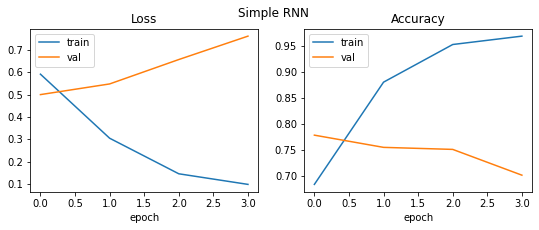

In [16]:
plt.figure(figsize=(9,3))
plt.suptitle('Simple RNN')

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(rnn_history.history['loss'], label='train')
plt.plot(rnn_history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(rnn_history.history['accuracy'], label='train')
plt.plot(rnn_history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')


In [17]:
# model 2: LSTM
lstm = Sequential()
lstm.add(
    Embedding(
      input_dim=num_words,
      output_dim=32,
      input_length=maxlen,
      )
    )

lstm.add(LSTM(64, return_sequences=False, return_state=False))
lstm.add(Dense(1, activation='sigmoid'))
lstm.summary()

# compiling
optimizer = Adam()
loss = BinaryCrossentropy()
lstm.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [18]:
# training 
earlystopping = EarlyStopping(patience=3)
file_path = working_dir + '/checkpoint/'
checkpointer = ModelCheckpoint(
    file_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    )

lstm_history = lstm.fit(
    X_train,
    y_train,
    validation_data=[X_val, y_val],
    epochs=10,
    callbacks=[earlystopping, checkpointer],
    batch_size=32
)

Epoch 1/10
215/215 [==============================] - 13s 42ms/step - loss: 0.5687 - accuracy: 0.6954 - val_loss: 0.4783 - val_accuracy: 0.7874
Epoch 2/10
215/215 [==============================] - 6s 29ms/step - loss: 0.3404 - accuracy: 0.8589 - val_loss: 0.4911 - val_accuracy: 0.7690
Epoch 3/10
215/215 [==============================] - 8s 39ms/step - loss: 0.2319 - accuracy: 0.9118 - val_loss: 0.6023 - val_accuracy: 0.7454
Epoch 4/10
215/215 [==============================] - 6s 30ms/step - loss: 0.1671 - accuracy: 0.9368 - val_loss: 0.7101 - val_accuracy: 0.7533


Text(0.5, 0, 'epoch')

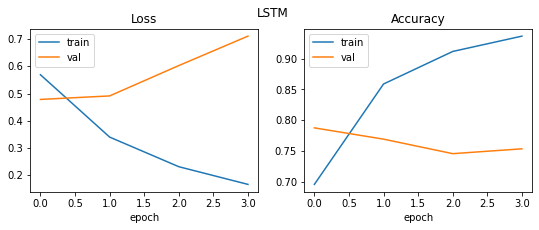

In [19]:
plt.figure(figsize=(9,3))
plt.suptitle('LSTM')

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')


In [20]:
# model 3: GRU
gru = Sequential()
gru.add(
    Embedding(
      input_dim=num_words,
      output_dim=32,
      input_length=maxlen,
      )
    )

gru.add(GRU(64, return_sequences=False, return_state=False))
gru.add(Dense(1, activation='sigmoid'))
gru.summary()

# compiling
optimizer = Adam()
loss = BinaryCrossentropy()
gru.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 32)            320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


In [21]:
# training 
earlystopping = EarlyStopping(patience=3)
file_path = working_dir + '/checkpoint/'
checkpointer = ModelCheckpoint(
    file_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    )

gru_history = gru.fit(
    X_train,
    y_train,
    validation_data=[X_val, y_val],
    epochs=10,
    callbacks=[earlystopping, checkpointer],
    batch_size=32
)

Epoch 1/10
215/215 [==============================] - 18s 41ms/step - loss: 0.5534 - accuracy: 0.7098 - val_loss: 0.4525 - val_accuracy: 0.8031
Epoch 2/10
215/215 [==============================] - 12s 54ms/step - loss: 0.3323 - accuracy: 0.8664 - val_loss: 0.4947 - val_accuracy: 0.7730
Epoch 3/10
215/215 [==============================] - 13s 58ms/step - loss: 0.2263 - accuracy: 0.9148 - val_loss: 0.5878 - val_accuracy: 0.7467
Epoch 4/10
215/215 [==============================] - 9s 41ms/step - loss: 0.1666 - accuracy: 0.9358 - val_loss: 0.6825 - val_accuracy: 0.7612


Text(0.5, 0, 'epoch')

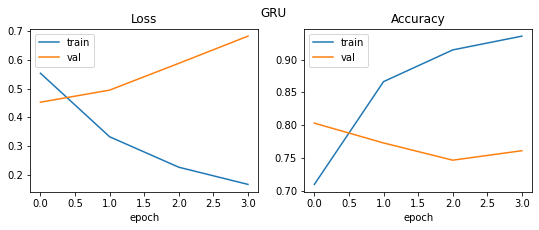

In [22]:
plt.figure(figsize=(9,3))
plt.suptitle('GRU')

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(gru_history.history['loss'], label='train')
plt.plot(gru_history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(gru_history.history['accuracy'], label='train')
plt.plot(gru_history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

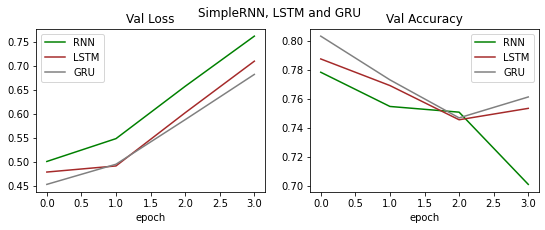

In [23]:
# Compare three models

plt.figure(figsize=(9,3))
plt.suptitle('SimpleRNN, LSTM and GRU')

plt.subplot(1,2,1)
plt.title('Val Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN', color='green')
plt.plot(lstm_history.history['val_loss'], label='LSTM', color='brown')
plt.plot(gru_history.history['val_loss'], label='GRU', color='gray')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.title('Val Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN', color='green')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM', color='brown')
plt.plot(gru_history.history['val_accuracy'], label='GRU', color='gray')
plt.legend()
plt.xlabel('epoch')
